# Code from here https://spark-in.me/post/unet-adventures-part-one-getting-acquainted-with-unet

# another simple example https://www.kaggle.com/toregil/a-lung-u-net-in-keras/code

In [14]:
import os
import smtplib

os.environ["CUDA_VISIBLE_DEVICES"]="1" #Comment this line out if you want all GPUS (2 hehe)

def notify_me(msg):
    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.starttls()
    with open('/home/tkyono/.emailsettings') as f:
        content = f.readlines()
    content = [x.strip() for x in content] 
    server.login(content[0], content[1])
    server.sendmail('DeepLearningBox', '8084460540@vtext.com', msg)

In [15]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)




In [16]:
import numpy as np
import pylab
def normalize(A):
    return (A - np.min(A)) / (np.max(A) - np.min(A))
    
def standardize(A): 
    return (A - np.mean(A)) / np.std(A)

def crop(img, hoff, woff, h_crop = 325, w_crop = 250):
    h, w, c = img.shape
    start_h = int(h/2 - w/2 + hoff)
    return img[start_h : start_h + h_crop, woff: woff + w_crop]

import random

import cv2
from random import randint as roll

#12, 25, 50 or 100 for full
scale = 12
img_rows = 325
img_cols = 250
def preprocess(img, augment = True):
    img = CLAHE3d(np.uint16(img))
    img = standardize(img)
    if augment:
        y_shift = roll(-scale, scale)
        x_shift = roll(0,scale)
        img = crop(img, y_shift, x_shift, img_rows, img_cols)
        img = add_gaussian_noise(img , 0.01)
        return normalize(img)
    else:
        img = crop(img, 0, 0, img_rows, img_cols)
        return normalize(img)


def show_img(img):
    pylab.imshow(img)
    pylab.colorbar()
    pylab.show()

def add_gaussian_noise(image_in, noise_sigma):
    temp_image = np.float64(np.copy(image_in))
    h = temp_image.shape[0]
    w = temp_image.shape[1]
    noise = np.random.randn(h, w) * noise_sigma
    noisy_image = np.zeros(temp_image.shape, np.float64)
    if len(temp_image.shape) == 2:
        noisy_image = temp_image + noise
    else:
        noisy_image[:,:,0] = temp_image[:,:,0] + noise
        noisy_image[:,:,1] = temp_image[:,:,1] + noise
        noisy_image[:,:,2] = temp_image[:,:,2] + noise
    return noisy_image
def CLAHE3d(img):
    #print("CLAHE")
    #print(img.shape)
    img = np.uint16(img)

    ret = []
    for i in range(len(img)):
        red_hist = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        green_hist =cv2.createCLAHE(clipLimit=4.0, tileGridSize=(4,4))
        blue_hist =cv2.createCLAHE(clipLimit=8.0, tileGridSize=(2,2))
        red = normalize(red_hist.apply(img[i]))
        green = normalize(green_hist.apply(img[i]))
        blue = normalize(blue_hist.apply(img[i]))
        ret.append((np.stack((red,green,blue), axis = 2)))
    return ret

In [17]:

from PIL import Image
from keras.preprocessing import image

def get_generator(train_folder, train_mask_folder, valid_folder, valid_mask_folder,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    rotation_range=10,
                    zoom_range=0.2,
                    samplewise_center = False,
                    samplewise_std_normalization = False,
                    #rescale = 1/65535.0,
                  #rescale = 1,  
                  classes=['keras'],
                    fill_mode="constant"):

    #batch_size = 12
    seed = 42
    image_datagen = ImageDataGenerator(width_shift_range=width_shift_range,
                        height_shift_range=height_shift_range,
                        horizontal_flip=horizontal_flip,
                        rotation_range=rotation_range,
                        zoom_range=zoom_range,
                        samplewise_center = samplewise_center,
                        samplewise_std_normalization = samplewise_std_normalization,
                        #rescale = rescale,
                        fill_mode=fill_mode, 
                        cval=0       )
    mask_datagen = ImageDataGenerator(width_shift_range=width_shift_range,
                        height_shift_range=height_shift_range,
                        horizontal_flip=horizontal_flip,
                        rotation_range=rotation_range,
                        zoom_range=zoom_range,
                        fill_mode=fill_mode,
                        cval=0    )
    
    val_datagen = ImageDataGenerator(#rescale = rescale,
                       # samplewise_center = True,
                       # samplewise_std_normalization = True,
)
    val_mask_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_directory(train_folder,
        batch_size = batch_size,target_size = (img_rows,img_cols),
        class_mode=None,
        color_mode='grayscale',
        #classes=classes,
        seed=seed
    )
    mask_generator = mask_datagen.flow_from_directory(train_mask_folder,
        batch_size = batch_size, target_size = (img_rows,img_cols),    
        class_mode=None,
        color_mode='grayscale',
        #classes=classes,
        seed=seed)

    
    valid_image_generator = val_datagen.flow_from_directory(valid_folder,
        batch_size = batch_size,target_size = (img_rows,img_cols),
        class_mode=None,
        color_mode='grayscale',
        #classes=classes,
        seed=seed)
    valid_mask_generator = val_mask_datagen.flow_from_directory(valid_mask_folder,
        batch_size = batch_size,target_size = (img_rows,img_cols),    
        class_mode=None,
        color_mode='grayscale',
        #$classes=classes,
        seed=seed)
    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)
    valid_generator = zip(valid_image_generator, valid_mask_generator)   
    return train_generator,valid_generator

In [ ]:
img_rows = 416
img_cols = 320
#model = UNet((img_rows,img_cols,1), dropout = 0.2)
model = get_unet()
plot_model(model, to_file='unet1.png', show_shapes=True)

batch_size = 10


image_dir = '/home/tkyono/Desktop/ddsm_unet_blurred'
#image_dir = '/home/tkyono/Desktop/UNET'
train_dir = image_dir + '/train/'
val_dir = image_dir + '/val/'

train_gen, val_gen = get_generator(train_dir + 'img/',
                                   train_dir + 'mask/',
                                    val_dir + 'img/',
                                   val_dir + 'mask/'
                                   )


nb_train_samples = 0
for filename in glob.glob(os.path.join(train_dir, '*/*/*.png')):
    nb_train_samples += 1
print("Found NB train samples = ", nb_train_samples)
nb_val_samples = 0
for filename in glob.glob(os.path.join(val_dir, '*/*/*.png')):
    nb_val_samples += 1
print("Found NB val samples = ", nb_val_samples)

def format_gen_outputs(gen):
    return np.array(CLAHE3d(gen[0])),gen[1]
    #return gen[0]/255, gen[1]

model.compile(optimizer=optimizers.Adam(lr = 1e-4),
              metrics =[dice_coef],
             loss = "binary_crossentropy"
             )  
'''
model.fit_generator(train_gen, epochs=200,
                steps_per_epoch=nb_train_samples // batch_size,
                verbose=1,workers=4,
                validation_data = val_gen,
                validation_steps = nb_val_samples // batch_size,
                #class_weight = class_weight,callbacks = callbacks, 
               )

'''

model.fit_generator(map(format_gen_outputs, train_gen), epochs=200,
                steps_per_epoch=nb_train_samples // batch_size,
                verbose=1,workers=4,
                validation_data = map(format_gen_outputs, val_gen),
                validation_steps = nb_val_samples // batch_size,
                #class_weight = class_weight,callbacks = callbacks, 
               )

Found 3081 images belonging to 3081 classes.
Found 3081 images belonging to 3081 classes.
Found 105 images belonging to 105 classes.
Found 105 images belonging to 105 classes.
Found NB train samples =  6162
Found NB val samples =  210
Epoch 1/200
 24/616 [>.............................] - ETA: 4:02 - loss: 0.7305 - dice_coef: 0.0144

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


for x,y in map(format_gen_outputs, train_gen):
    
    yout = model.predict(x)
    plt.imshow(np.reshape(x[0], (416,320)))
    plt.show()
    print(np.max(y[0]), np.min(y[0]))

    plt.imshow(np.reshape(np.asarray(y[0]), (416,320)))
    
    plt.colorbar()
    plt.show()

AttributeError: 'map' object has no attribute 'ndim'

In [ ]:
model.compile(optimizer=optimizers.Adam(lr = 1e-5),
              metrics =[dice_coef_loss],
             loss = "binary_crossentropy"
             )  
model.fit_generator(train_gen, epochs=200,
                steps_per_epoch=nb_train_samples // batch_size,
                verbose=1,workers=4,
                validation_data = val_gen,
                validation_steps = nb_val_samples // batch_size,
                #class_weight = class_weight,callbacks = callbacks, 
               )

In [ ]:
    
val_datagen = ImageDataGenerator(rescale = 1/255)
val_mask_datagen = ImageDataGenerator()

valid_image_generator = val_datagen.flow_from_directory(valid_folder,
    batch_size = batch_size,target_size = (416,320),
    class_mode=None,
    color_mode='grayscale',
    #classes=classes,
    seed=seed)
valid_mask_generator = val_mask_datagen.flow_from_directory(valid_mask_folder,
    batch_size = batch_size,target_size = (416,320),    
    class_mode=None,
    color_mode='grayscale',
    #$classes=classes,
    seed=seed)
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)
valid_generator = zip(valid_image_generator, valid_mask_generator)   

# Print the model outputs!

Found 3081 images belonging to 3081 classes.
Found 3081 images belonging to 3081 classes.
Found 105 images belonging to 105 classes.
Found 105 images belonging to 105 classes.
(416, 320, 3) (416, 320, 1)
1.0 0.0


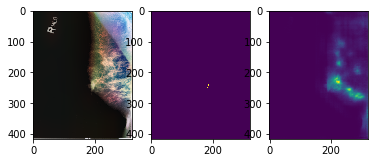

(416, 320, 3) (416, 320, 1)
1.0 0.0


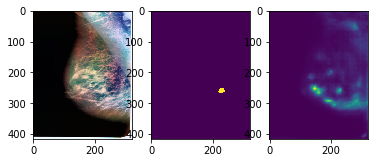

(416, 320, 3) (416, 320, 1)
1.0 0.0


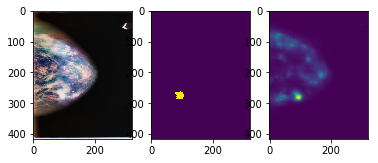

(416, 320, 3) (416, 320, 1)
1.0 0.0


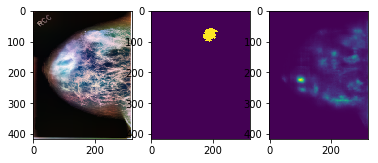

(416, 320, 3) (416, 320, 1)
1.0 0.0


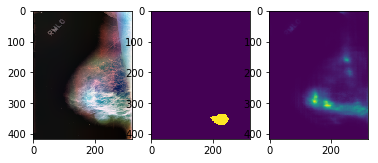

(416, 320, 3) (416, 320, 1)
1.0 0.0


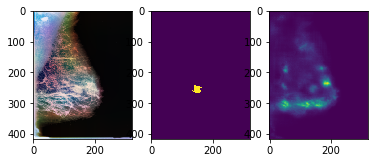

(416, 320, 3) (416, 320, 1)
1.0 0.0


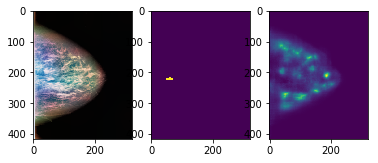

(416, 320, 3) (416, 320, 1)
1.0 0.0


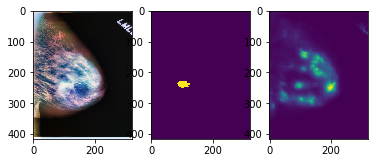

(416, 320, 3) (416, 320, 1)
1.0 0.0


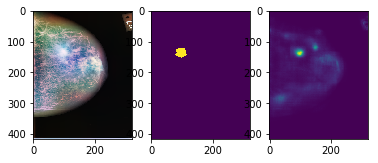

(416, 320, 3) (416, 320, 1)
1.0 0.0


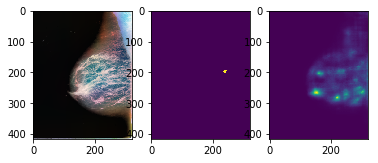

(416, 320, 3) (416, 320, 1)
1.0 0.0


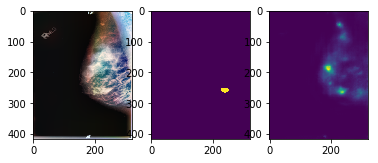

(416, 320, 3) (416, 320, 1)
1.0 0.0


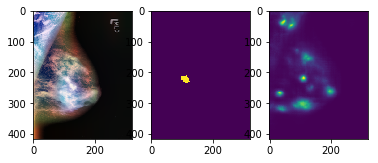

(416, 320, 3) (416, 320, 1)
1.0 0.0


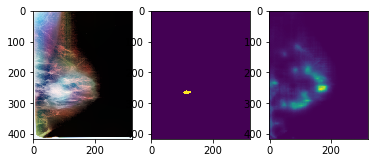

(416, 320, 3) (416, 320, 1)
1.0 0.0


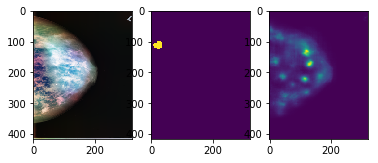

(416, 320, 3) (416, 320, 1)
1.0 0.0


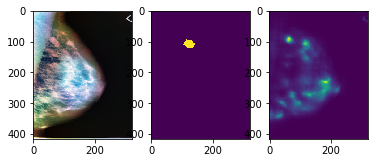

(416, 320, 3) (416, 320, 1)
1.0 0.0


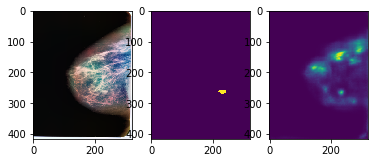

(416, 320, 3) (416, 320, 1)
1.0 0.0


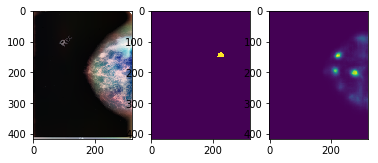

(416, 320, 3) (416, 320, 1)
1.0 0.0


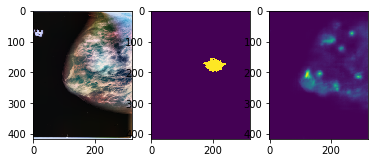

(416, 320, 3) (416, 320, 1)
1.0 0.0


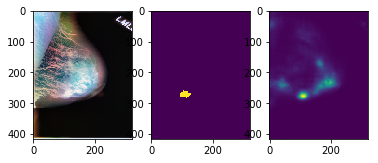

(416, 320, 3) (416, 320, 1)
1.0 0.0


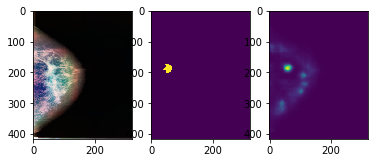

(416, 320, 3) (416, 320, 1)
1.0 0.0


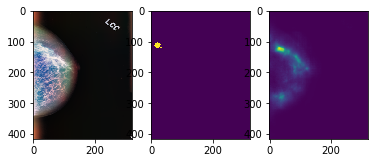

(416, 320, 3) (416, 320, 1)
1.0 0.0


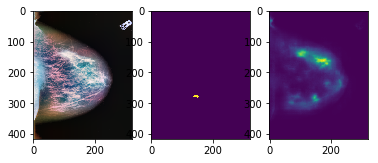

(416, 320, 3) (416, 320, 1)
1.0 0.0


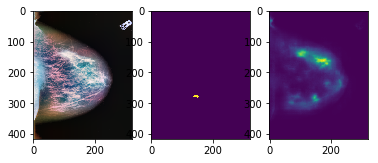

(416, 320, 3) (416, 320, 1)
1.0 0.0


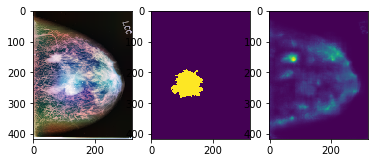

(416, 320, 3) (416, 320, 1)
1.0 0.0


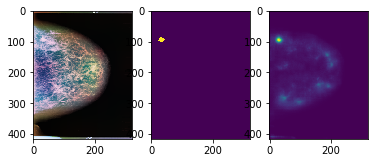

(416, 320, 3) (416, 320, 1)
1.0 0.0


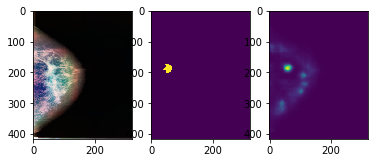

(416, 320, 3) (416, 320, 1)
1.0 0.0


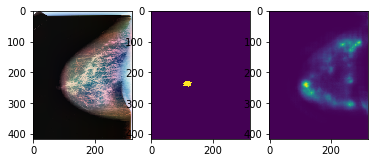

(416, 320, 3) (416, 320, 1)
1.0 0.0


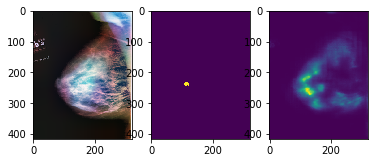

(416, 320, 3) (416, 320, 1)
1.0 0.0


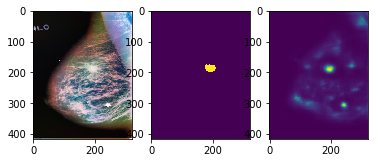

(416, 320, 3) (416, 320, 1)
1.0 0.0


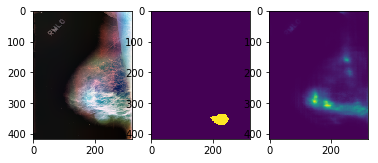

(416, 320, 3) (416, 320, 1)
1.0 0.0


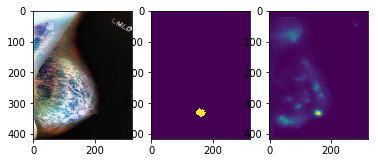

(416, 320, 3) (416, 320, 1)
1.0 0.0


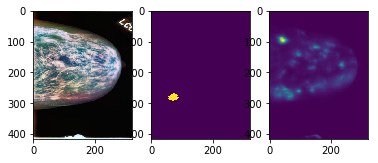

(416, 320, 3) (416, 320, 1)
1.0 0.0


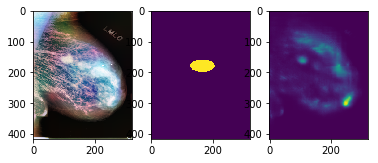

(416, 320, 3) (416, 320, 1)
1.0 0.0


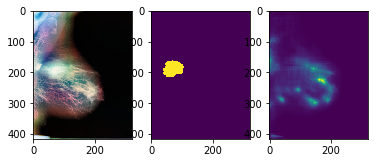

(416, 320, 3) (416, 320, 1)
1.0 0.0


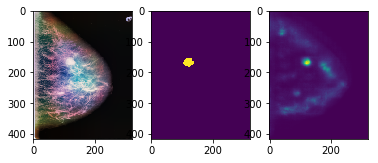

(416, 320, 3) (416, 320, 1)
1.0 0.0


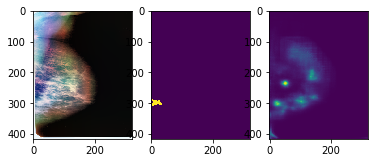

(416, 320, 3) (416, 320, 1)
1.0 0.0


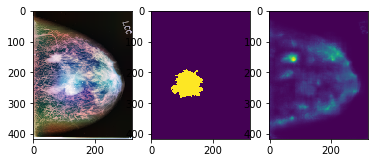

(416, 320, 3) (416, 320, 1)
1.0 0.0


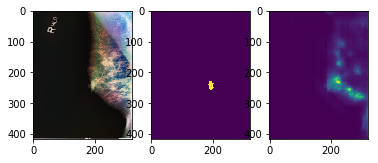

(416, 320, 3) (416, 320, 1)
1.0 0.0


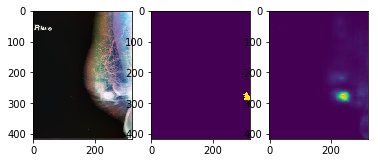

(416, 320, 3) (416, 320, 1)
1.0 0.0


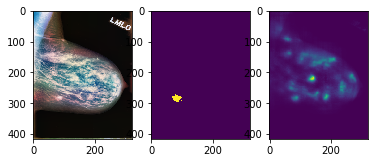

(416, 320, 3) (416, 320, 1)
1.0 0.0


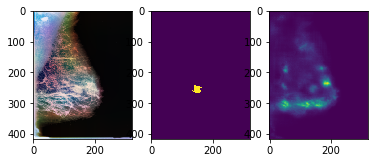

(416, 320, 3) (416, 320, 1)
1.0 0.0


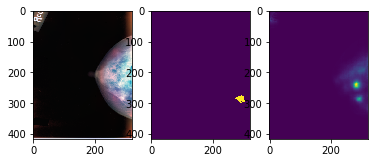

(416, 320, 3) (416, 320, 1)
1.0 0.0


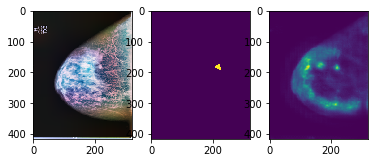

(416, 320, 3) (416, 320, 1)
1.0 0.0


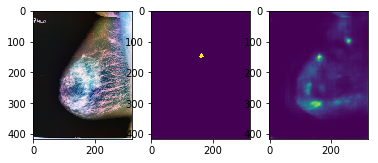

(416, 320, 3) (416, 320, 1)
1.0 0.0


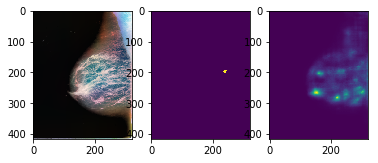

(416, 320, 3) (416, 320, 1)
1.0 0.0


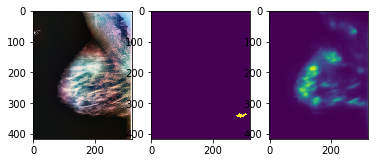

(416, 320, 3) (416, 320, 1)
1.0 0.0


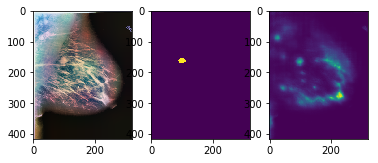

(416, 320, 3) (416, 320, 1)
1.0 0.0


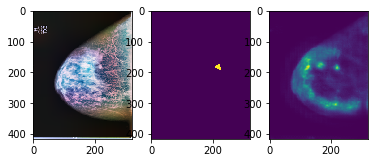

(416, 320, 3) (416, 320, 1)
1.0 0.0


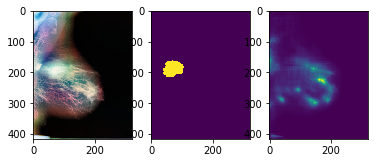

(416, 320, 3) (416, 320, 1)
1.0 0.0


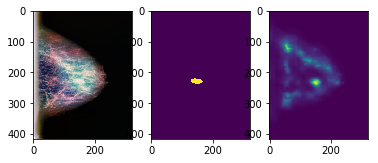

(416, 320, 3) (416, 320, 1)
1.0 0.0


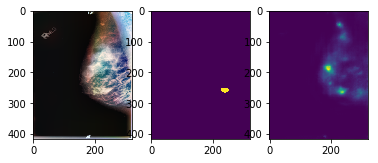

(416, 320, 3) (416, 320, 1)
1.0 0.0


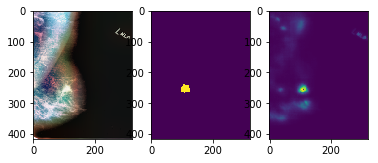

(416, 320, 3) (416, 320, 1)
1.0 0.0


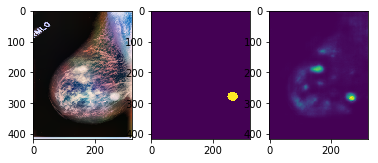

(416, 320, 3) (416, 320, 1)
1.0 0.0


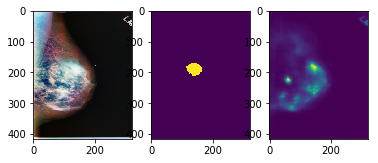

(416, 320, 3) (416, 320, 1)
1.0 0.0


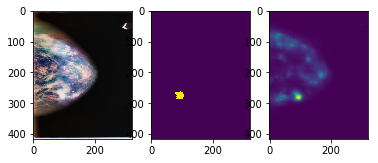

(416, 320, 3) (416, 320, 1)
1.0 0.0


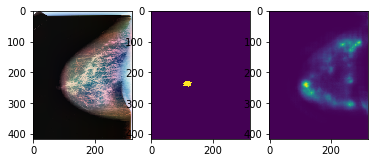

(416, 320, 3) (416, 320, 1)
1.0 0.0


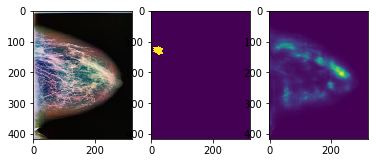

(416, 320, 3) (416, 320, 1)
1.0 0.0


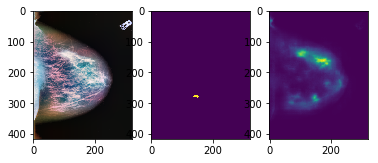

(416, 320, 3) (416, 320, 1)
1.0 0.0


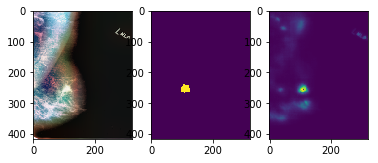

(416, 320, 3) (416, 320, 1)
1.0 0.0


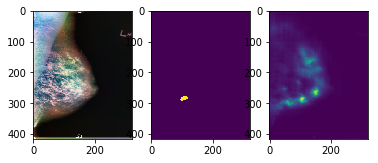

(416, 320, 3) (416, 320, 1)
1.0 0.0


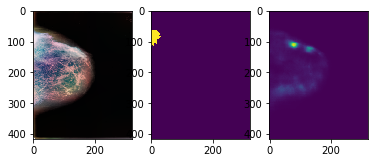

(416, 320, 3) (416, 320, 1)
1.0 0.0


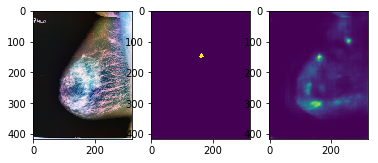

(416, 320, 3) (416, 320, 1)
1.0 0.0


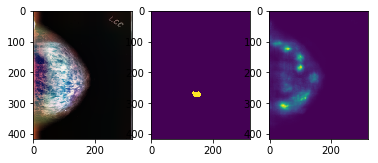

(416, 320, 3) (416, 320, 1)
1.0 0.0


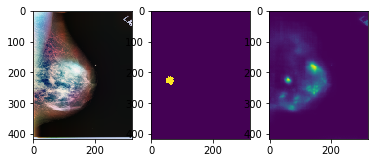

(416, 320, 3) (416, 320, 1)
1.0 0.0


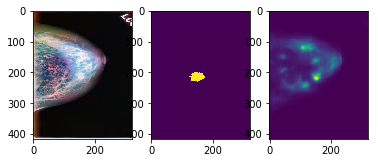

(416, 320, 3) (416, 320, 1)
1.0 0.0


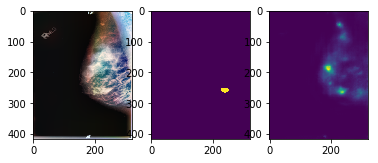

(416, 320, 3) (416, 320, 1)
1.0 0.0


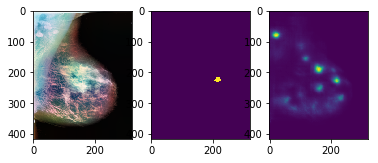

(416, 320, 3) (416, 320, 1)
1.0 0.0


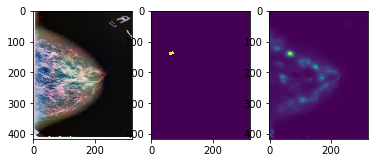

(416, 320, 3) (416, 320, 1)
1.0 0.0


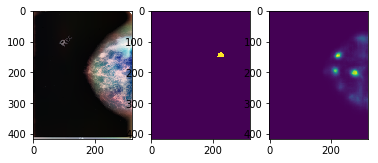

(416, 320, 3) (416, 320, 1)
1.0 0.0


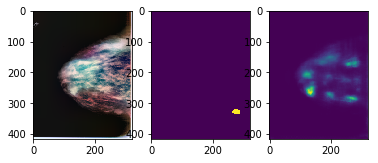

(416, 320, 3) (416, 320, 1)
1.0 0.0


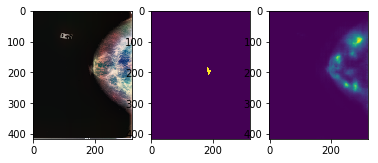

(416, 320, 3) (416, 320, 1)
1.0 0.0


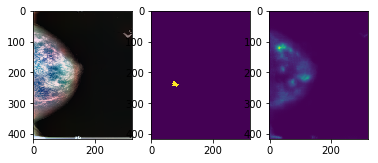

(416, 320, 3) (416, 320, 1)
1.0 0.0


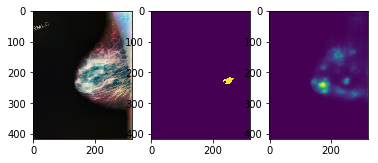

(416, 320, 3) (416, 320, 1)
1.0 0.0


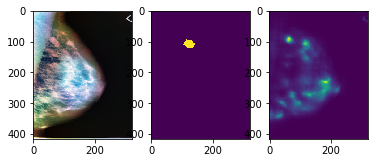

(416, 320, 3) (416, 320, 1)
1.0 0.0


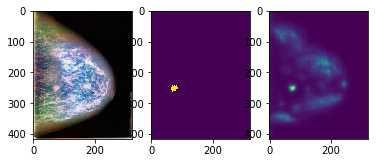

(416, 320, 3) (416, 320, 1)
1.0 0.0


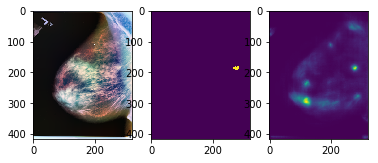

(416, 320, 3) (416, 320, 1)
1.0 0.0


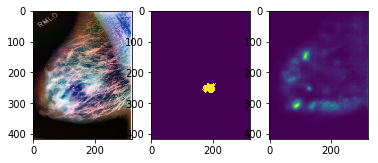

(416, 320, 3) (416, 320, 1)
1.0 0.0


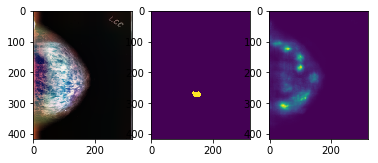

(416, 320, 3) (416, 320, 1)
1.0 0.0


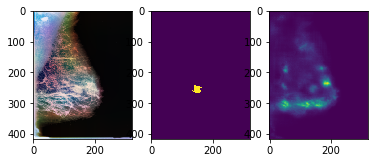

(416, 320, 3) (416, 320, 1)
1.0 0.0


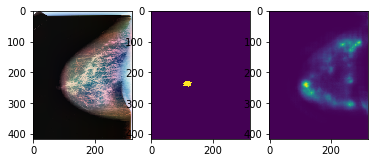

(416, 320, 3) (416, 320, 1)
1.0 0.0


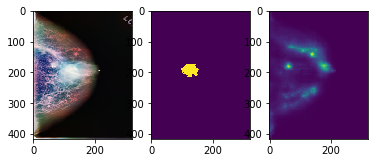

(416, 320, 3) (416, 320, 1)
1.0 0.0


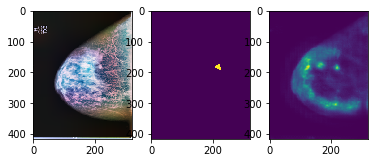

(416, 320, 3) (416, 320, 1)
1.0 0.0


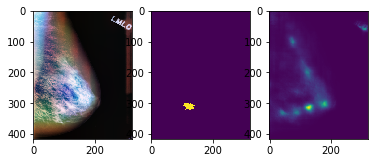

(416, 320, 3) (416, 320, 1)
1.0 0.0


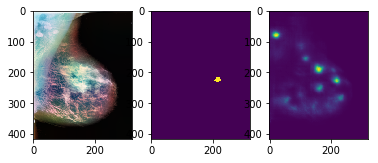

(416, 320, 3) (416, 320, 1)
1.0 0.0


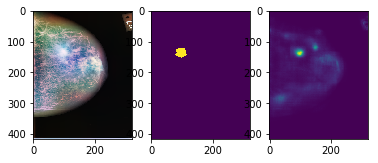

(416, 320, 3) (416, 320, 1)
1.0 0.0


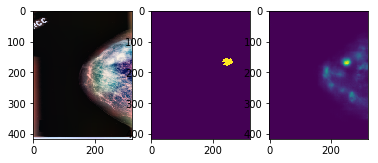

(416, 320, 3) (416, 320, 1)
1.0 0.0


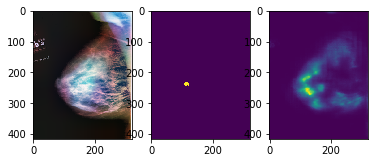

(416, 320, 3) (416, 320, 1)
1.0 0.0


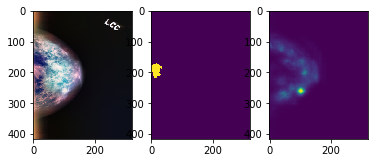

(416, 320, 3) (416, 320, 1)
1.0 0.0


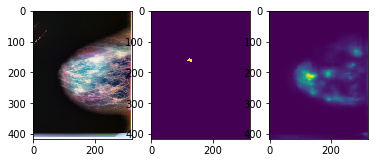

(416, 320, 3) (416, 320, 1)
1.0 0.0


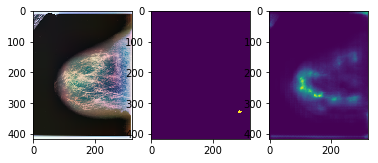

(416, 320, 3) (416, 320, 1)
1.0 0.0


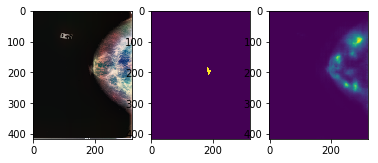

(416, 320, 3) (416, 320, 1)
1.0 0.0


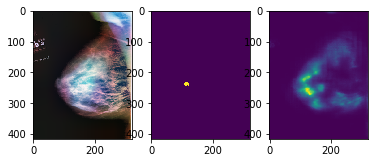

(416, 320, 3) (416, 320, 1)
1.0 0.0


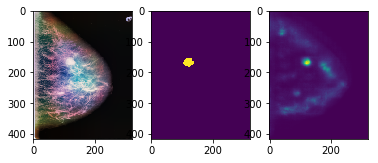

(416, 320, 3) (416, 320, 1)
1.0 0.0


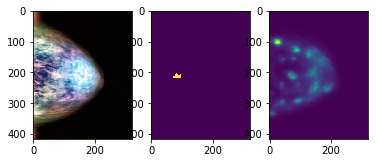

(416, 320, 3) (416, 320, 1)
1.0 0.0


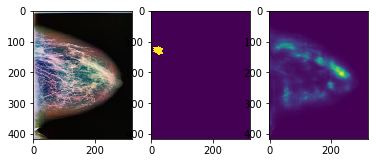

(416, 320, 3) (416, 320, 1)
1.0 0.0


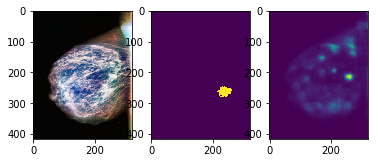

(416, 320, 3) (416, 320, 1)
1.0 0.0


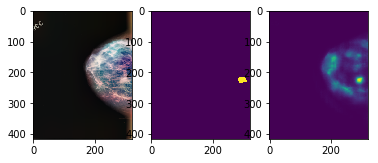

(416, 320, 3) (416, 320, 1)
1.0 0.0


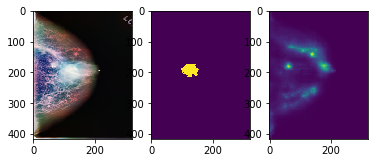

(416, 320, 3) (416, 320, 1)
1.0 0.0


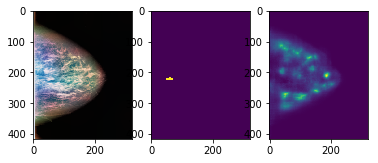

(416, 320, 3) (416, 320, 1)
1.0 0.0


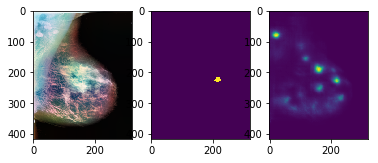

(416, 320, 3) (416, 320, 1)
1.0 0.0


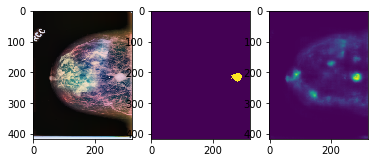

(416, 320, 3) (416, 320, 1)
1.0 0.0


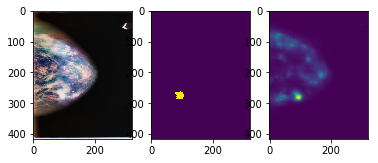

(416, 320, 3) (416, 320, 1)
1.0 0.0


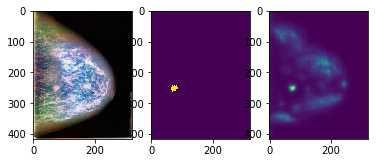

(416, 320, 3) (416, 320, 1)
1.0 0.0


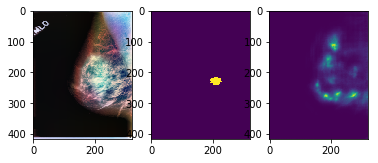

(416, 320, 3) (416, 320, 1)
1.0 0.0


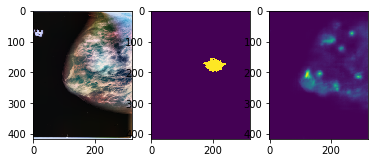

(416, 320, 3) (416, 320, 1)
1.0 0.0


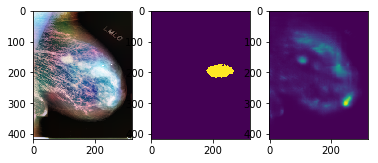

(416, 320, 3) (416, 320, 1)
1.0 0.0


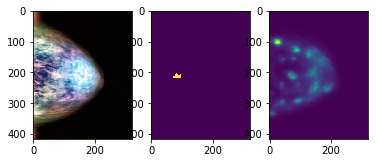

(416, 320, 3) (416, 320, 1)
1.0 0.0


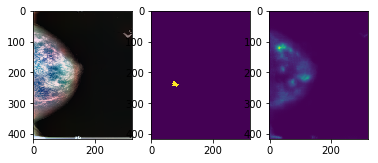

(416, 320, 3) (416, 320, 1)
1.0 0.0


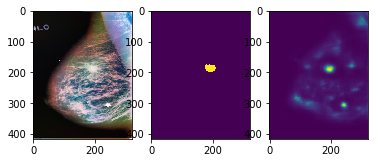

(416, 320, 3) (416, 320, 1)
1.0 0.0


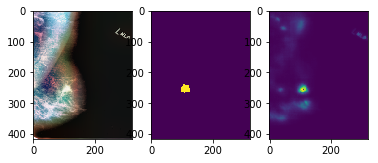

(416, 320, 3) (416, 320, 1)
1.0 0.0


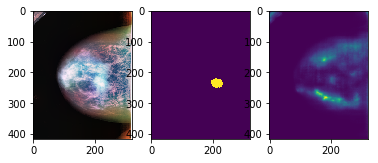

(416, 320, 3) (416, 320, 1)
1.0 0.0


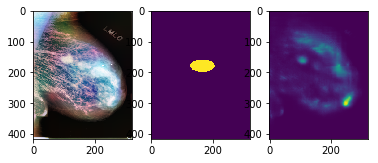

(416, 320, 3) (416, 320, 1)
1.0 0.0


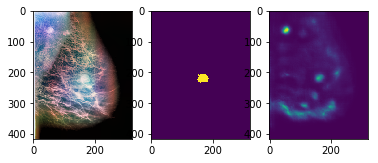

(416, 320, 3) (416, 320, 1)
1.0 0.0


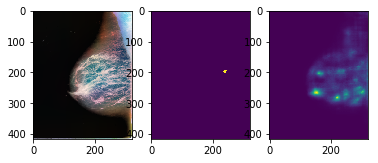

(416, 320, 3) (416, 320, 1)
1.0 0.0


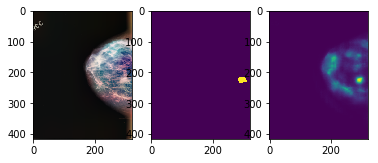

(416, 320, 3) (416, 320, 1)
1.0 0.0


KeyboardInterrupt: 

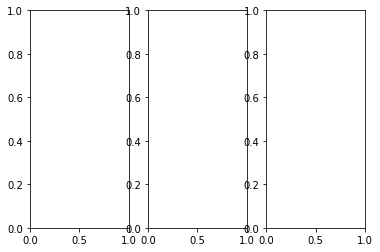

In [13]:
image_dir = '/home/tkyono/Desktop/ddsm_unet_masked'

val_dir = image_dir + '/val/'

train_gen, val_gen = get_generator(train_dir + 'img/',
                                   train_dir + 'mask/',
                                    val_dir + 'img/',
                                   val_dir + 'mask/'
                                   )


import numpy as np
import matplotlib.pyplot as plt
for x,y in map(format_gen_outputs, val_gen):
    print(x[0].shape, y[0].shape)
    print(np.max(x[0]), np.min(x[0]))
    
    f, axarr = plt.subplots(1,3)
    yout = model.predict(x/np.max(x))

    axarr[0].imshow(np.reshape(x[0],(416,320,3)))
    axarr[1].imshow(np.reshape(y[0], (416,320)))
    axarr[2].imshow(np.reshape(yout[0], (416,320)))

    plt.show()

# Unets!

In [6]:
from keras.applications.resnet50 import ResNet50
from keras.callbacks import LearningRateScheduler
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import concatenate, Conv2DTranspose
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, BatchNormalization
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.utils.training_utils import multi_gpu_model
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os


def get_unet():
    inputs = Input((img_rows, img_cols, 3))
    bn = BatchNormalization()(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bn)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = BatchNormalization()(pool1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = BatchNormalization()(pool4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    #model.compile(optimizer=optimizers.Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [ ]:
from keras.models import Input, Model
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization

'''
U-Net: Convolutional Networks for Biomedical Image Segmentation
(https://arxiv.org/abs/1505.04597)
---
img_shape: (height, width, channels)
out_ch: number of output channels
start_ch: number of channels of the first conv
depth: zero indexed depth of the U-structure
inc_rate: rate at which the conv channels will increase
activation: activation function after convolutions
dropout: amount of dropout in the contracting part
batchnorm: adds Batch Normalization if true
maxpool: use strided conv instead of maxpooling if false
upconv: use transposed conv instead of upsamping + conv if false
residual: add residual connections around each conv block if true
'''

def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
    dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)
